In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogFormatter
import pickle
import os
import numpy as np

## Xeon Platinum 8175M Single Core Peak GFLOP/s

In [2]:
AVX512_FLOPS_PER_CYCLE = 8*2 # DP FMA
NUM_AVX512_UNITS = 2
AVX512_FREQ = 2.4 # All Cores Active AVX512 Boost (GHz)
XEON_8175M_PEAK_FLOPS = AVX512_FREQ * NUM_AVX512_UNITS * AVX512_FLOPS_PER_CYCLE

In [3]:
XEON_8175M_PEAK_FLOPS

76.8

## Xeon Platinum 8175M Single Core Tuned STREAM BW

In [4]:
XEON_8175M_PEAK_BW = 13.5163 # GB/s

## Load FLOP/s of benchmark

In [5]:
from calc_pseudo import clean, basic_flops
B_TARGET_PANEL_WIDTH = 48
MAT_PATH = "./../../../example_mats_med/"
mat_paths = sum([[os.path.join(dir, file) for file in files] for dir, _, files in os.walk(MAT_PATH)], [])
mat_FLOPS = {}
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    
    mat_FLOPS[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL

In [9]:
LN2_DIR = "./../../../logs/regpack_macc/regpack_ln2/pyfr/"
LN3_DIR = "./../../../logs/regpack_macc/regpack_ln3/pyfr/"

LM2_DIR = "./../../../logs/regpack_macc/regpack_lm2/pyfr/"
LM3_DIR = "./../../../logs/regpack_macc/regpack_lm3/pyfr/"

RP_DIR     = "./../../../logs/reg_pack/pyfr/"
DENSE_DIR  = "./../../../logs/reg_pack/pyfr/dense/"

In [10]:
ln2_runs = []
ln3_runs = []
lm2_runs = []
lm3_runs = []
rp_runs = []
dense_runs = []

In [11]:
NUM_RUNS = 3

for i in range(1,NUM_RUNS+1):
    with open(LN2_DIR+"run_{}.dat".format(i), "rb") as f:
        ln2_runs.append( pickle.load(f) )
    with open(LN3_DIR+"run_{}.dat".format(i), "rb") as f:
        ln3_runs.append( pickle.load(f) )
    with open(LM2_DIR+"run_{}.dat".format(i), "rb") as f:
        lm2_runs.append( pickle.load(f) )
    with open(LM3_DIR+"run_{}.dat".format(i), "rb") as f:
        lm3_runs.append( pickle.load(f) )
    with open(RP_DIR+"run_{}.dat".format(i), "rb") as f:
        rp_runs.append( pickle.load(f) )
    with open(DENSE_DIR+"run_{}.dat".format(i), "rb") as f:
        dense_runs.append( pickle.load(f) )

In [12]:
def calc_GFLOPs(mat_FLOPS, runs, t='best'):
    NUM_PANELS = 192000 / 48

    mat_names = runs[0]['mat_file']
    local_FLOPs = []
    ref_FLOPs = []

    for i, mat_name in enumerate(mat_names):
        FLOPS_PER_PANEL = mat_FLOPS[mat_name]
        local_best = []
        ref_best = []
        for r, run in enumerate(runs):
            time_per_panel_local = (run['xsmm_local_'+t][i]*1e-3)/NUM_PANELS
            time_per_panel_ref   = (run['xsmm_upstream_'+t][i]*1e-3)/NUM_PANELS

            local_best.append(FLOPS_PER_PANEL / time_per_panel_local)
            ref_best.append(FLOPS_PER_PANEL / time_per_panel_ref)
        local_avg = sum(local_best) / len(local_best)
        ref_avg = sum(ref_best) / len(ref_best)

        local_FLOPs.append(local_avg / 1e9)
        ref_FLOPs.append(ref_avg / 1e9)

    return mat_names, ref_FLOPs, local_FLOPs

## Load AI of benchmark

In [13]:
import math

def calc_mem_ref_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        has_A = False
        for el in col:
            if el != 0:
                has_A = True
        # at least one A - load stride of B into cache
        if has_A:
            mem += 8*8

    # store C
    for row in mat:
        has_A = False
        for el in row:
            if el != 0:
                has_A = True
        # at least one A - store a C stride
        if has_A:
            mem += 8*8

    return (mem * num_panels)# + mem_A # dont repeat A load

def calc_mem_ref_dense_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        mem += 8*8

    # store C
    for row in mat:
        mem += 8*8
        

    return (mem * num_panels)# + mem_A # dont repeat A load

def calc_mem_local_beta_0(mat, b_cols=48):
    # dont count A load
    # AVX_512_NUM_DP 8
    num_panels = b_cols/8
    # beta = 0
    mem = 0

    # load B
    for col in mat.T:
        has_A = False
        for el in col:
            if el != 0:
                has_A = True
        # at least one A - load stride of B into cache
        if has_A:
            mem += 8*8

    # store C
    for row in mat:
        has_A = False
        for el in row:
            if el != 0:
                has_A = True
        # at least one A - store a C stride
        if has_A:
            mem += 8*8

    # round A up to nearest multiple of 64 (cache line)
    # mem_A = int(math.ceil(mem_A / 64.0)) * 64
    return (mem * num_panels)# + mem_A # dont repeat A load

In [14]:
mat_AI_ref = {}
mat_AI_local = {}

for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    REF_MEM_PER_PANEL = calc_mem_ref_beta_0(test_mat)
    REF_DENSE_R_PANEL = calc_mem_ref_dense_beta_0(test_mat)
    LOCAL_MEM_PER_PANEL = calc_mem_local_beta_0(test_mat)

    mat_AI_ref[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL / REF_DENSE_R_PANEL
    mat_AI_local[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL / LOCAL_MEM_PER_PANEL

In [15]:
def get_AI(mat_AI_ref, mat_AI_local, mat_names, skip_local=False):
    ref_AIs, local_AIs = [], []
    
    for mat_name in mat_names:
        ref_AIs.append(mat_AI_ref[mat_name])
        if not skip_local:
            local_AIs.append(mat_AI_local[mat_name])
    
    return ref_AIs, local_AIs

# LM Blocking

In [23]:
shapes = ["quad", "hex", "tet", "tri"]
shape_title = ["Quad", "Hex", "Tet", "Tri"]

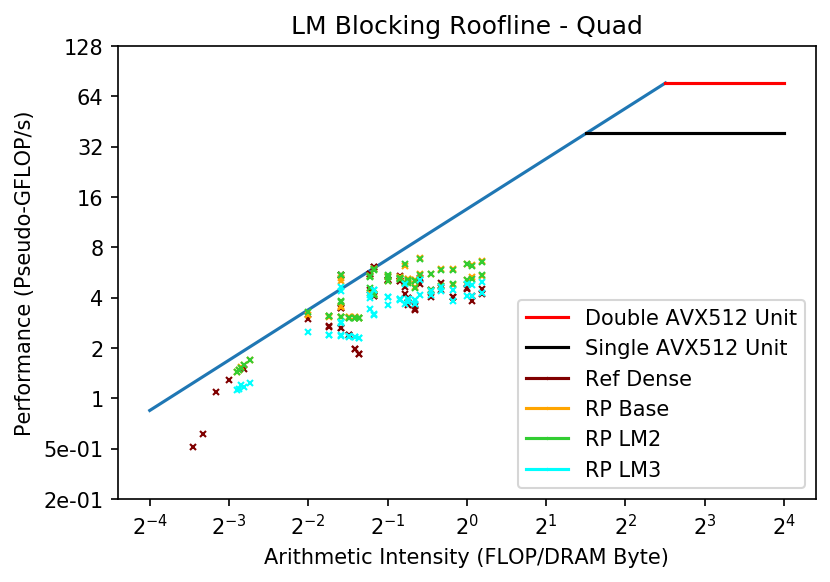

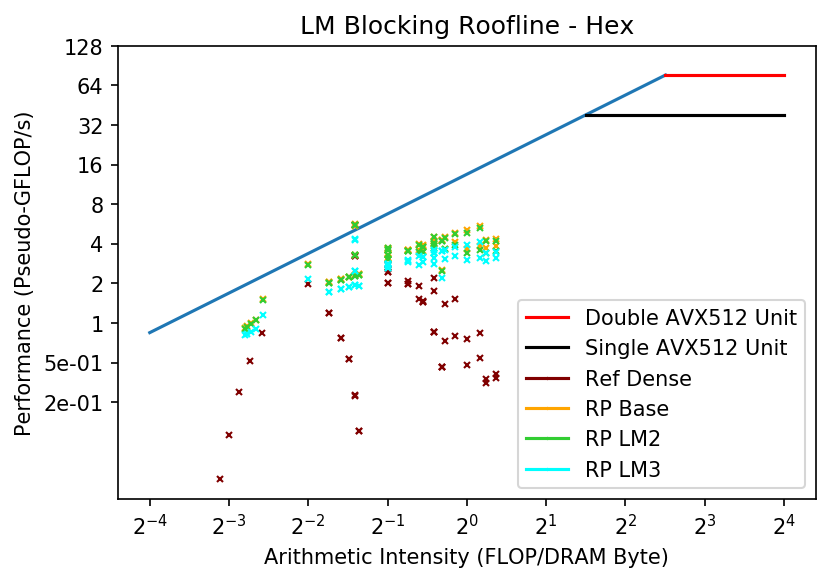

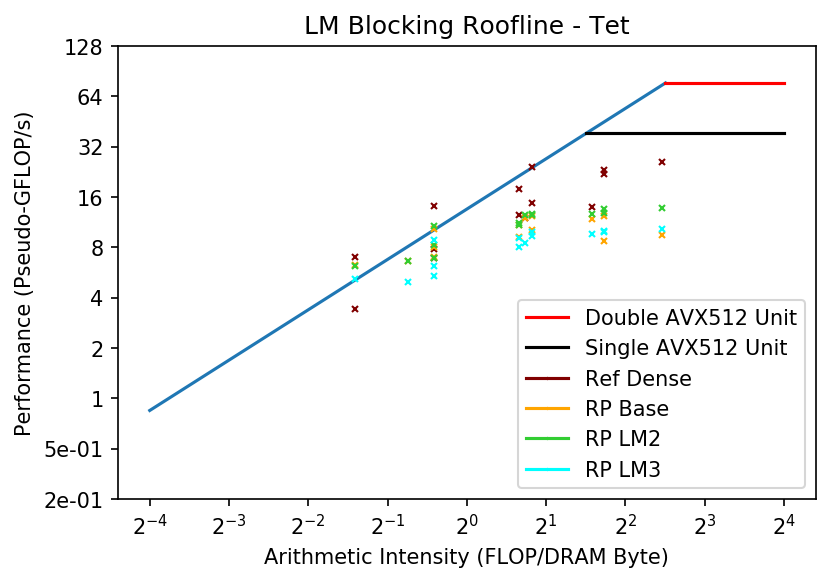

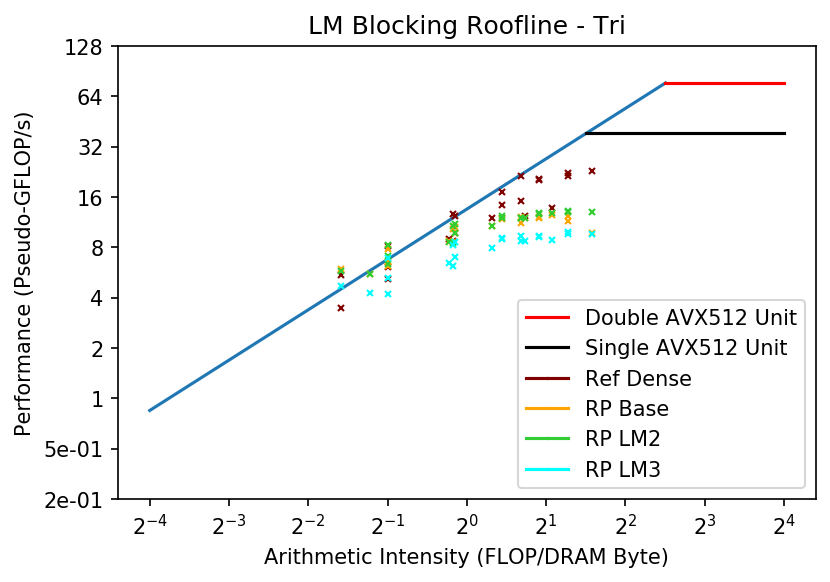

In [25]:
for i_title, shape in enumerate(shapes):
    mat_names, _, lm2_FLOPs = calc_GFLOPs(mat_FLOPS, [lm2_runs[0][shape], lm2_runs[1][shape], lm2_runs[2][shape]])
    _, _, lm3_FLOPs         = calc_GFLOPs(mat_FLOPS, [lm3_runs[0][shape], lm3_runs[1][shape], lm3_runs[2][shape]])
    _, _, rp_FLOPs          = calc_GFLOPs(mat_FLOPS, [rp_runs[0][shape], rp_runs[1][shape], rp_runs[2][shape]])
    _, dense_FLOPs, _       = calc_GFLOPs(mat_FLOPS, [dense_runs[0][shape], dense_runs[1][shape], dense_runs[2][shape]])

    ref_AIs, local_AIs = get_AI(mat_AI_ref, mat_AI_local, mat_names)

    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
    y = x*XEON_8175M_PEAK_BW
    ax.plot(x, y)
    x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
    y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
    ax.plot(x, y, color='red', label="Double AVX512 Unit")
    x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
    y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
    ax.plot(x, y, color='black', label="Single AVX512 Unit")

    ax.plot(ref_AIs[0], dense_FLOPs[0], marker='x', color='maroon', ms=1, label="Ref Dense")
    for i, mat_name in enumerate(mat_names):
        ax.plot(ref_AIs[i], dense_FLOPs[i], marker='x', color='maroon', ms=3)
    ax.plot(local_AIs[0], rp_FLOPs[0], marker='x', color='orange', ms=1, label="RP Base")
    for i, mat_name in enumerate(mat_names):
        ax.plot(local_AIs[i], rp_FLOPs[i], marker='x', color='orange', ms=3)


    ax.plot(local_AIs[0], lm2_FLOPs[0], marker='x', color='limegreen', ms=1, label="RP LM2")
    for i, mat_name in enumerate(mat_names):
        ax.plot(local_AIs[i], lm2_FLOPs[i], marker='x', color='limegreen', ms=3)

    ax.plot(local_AIs[0], lm3_FLOPs[0], marker='x', color='cyan', ms=1, label="RP LM3")
    for i, mat_name in enumerate(mat_names):
        ax.plot(local_AIs[i], lm3_FLOPs[i], marker='x', color='cyan', ms=3)

    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)
    ax.set_xticks([2**i for i in range(-4, 5)])
    ax.set_yticks([2**i for i in range(-2, 8)])
    #ax.xaxis.set_major_formatter(LogFormatter(base=2))
    ax.yaxis.set_major_formatter(LogFormatter(base=2))
    ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
    ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
    ax.set_title('LM Blocking Roofline - '+shape_title[i_title])
    plt.legend()
    plt.savefig("./../../../plots/regpack_macc/regpack_lm/pyfr/roofline/{}.pdf".format(shape))
    plt.show()

# LN Blocking

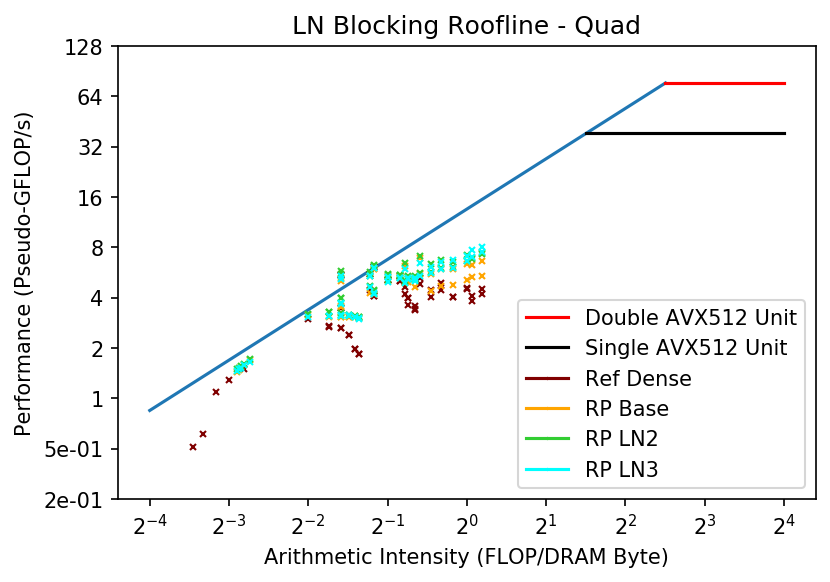

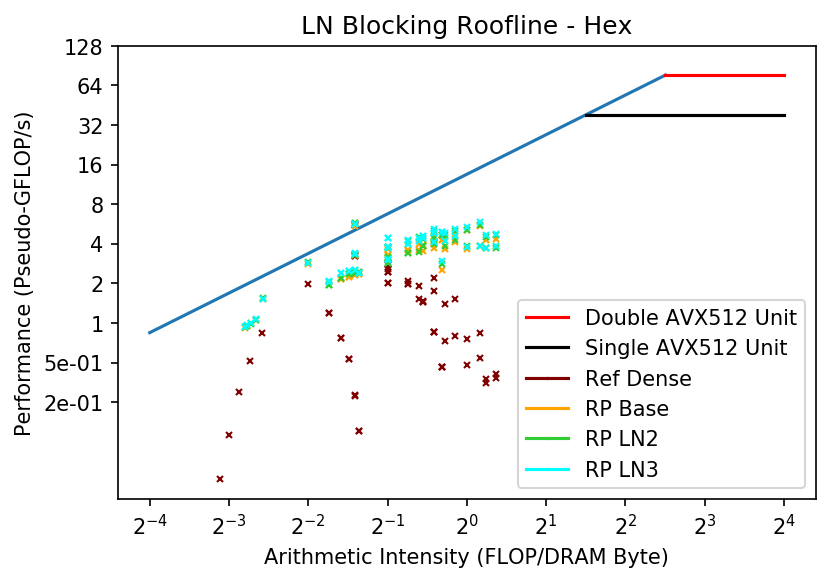

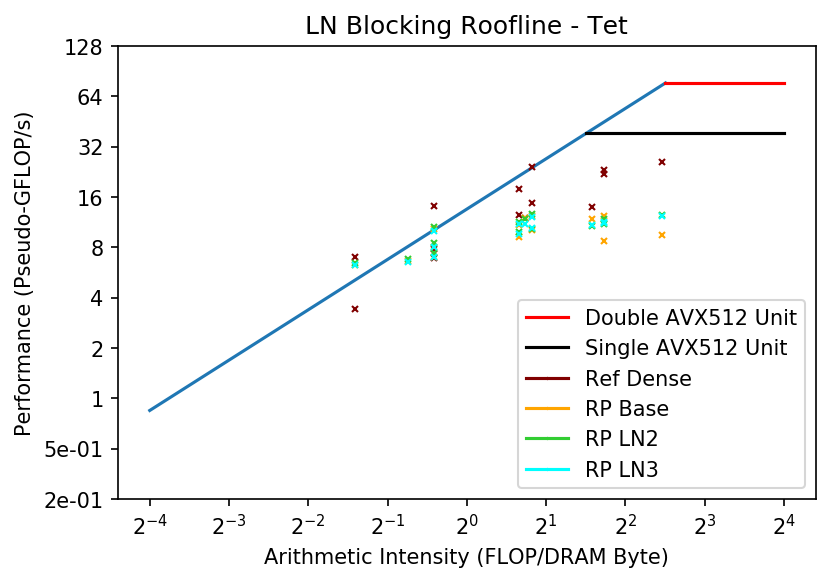

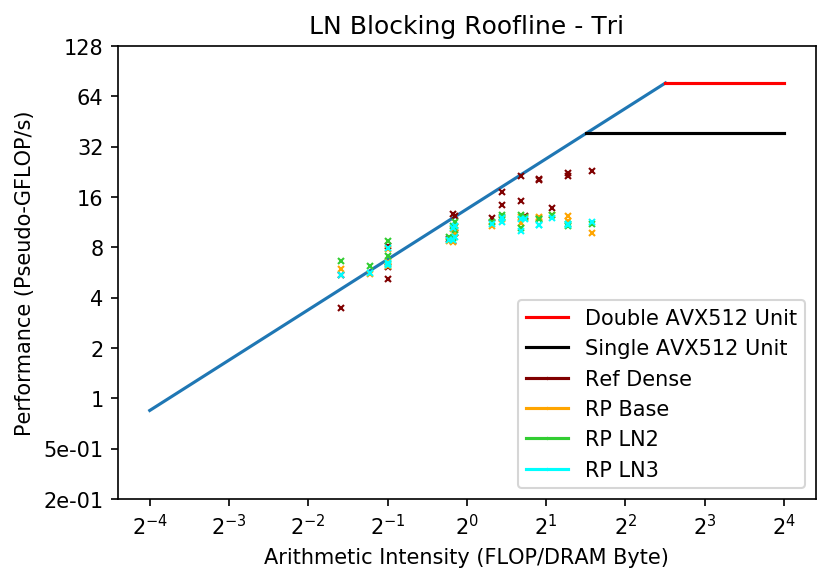

In [26]:
for i_title, shape in enumerate(shapes):
    mat_names, _, ln2_FLOPs = calc_GFLOPs(mat_FLOPS, [ln2_runs[0][shape], ln2_runs[1][shape], ln2_runs[2][shape]])
    _, _, ln3_FLOPs         = calc_GFLOPs(mat_FLOPS, [ln3_runs[0][shape], ln3_runs[1][shape], ln3_runs[2][shape]])
    _, _, rp_FLOPs          = calc_GFLOPs(mat_FLOPS, [rp_runs[0][shape], rp_runs[1][shape], rp_runs[2][shape]])
    _, dense_FLOPs, _       = calc_GFLOPs(mat_FLOPS, [dense_runs[0][shape], dense_runs[1][shape], dense_runs[2][shape]])

    ref_AIs, local_AIs = get_AI(mat_AI_ref, mat_AI_local, mat_names)

    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    x = np.array([2**(-4), XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW])
    y = x*XEON_8175M_PEAK_BW
    ax.plot(x, y)
    x = np.array([XEON_8175M_PEAK_FLOPS/XEON_8175M_PEAK_BW, 2**4])
    y = [XEON_8175M_PEAK_FLOPS,XEON_8175M_PEAK_FLOPS]
    ax.plot(x, y, color='red', label="Double AVX512 Unit")
    x = np.array([(XEON_8175M_PEAK_FLOPS/2)/XEON_8175M_PEAK_BW, 2**4])
    y = [(XEON_8175M_PEAK_FLOPS/2),(XEON_8175M_PEAK_FLOPS/2)]
    ax.plot(x, y, color='black', label="Single AVX512 Unit")

    ax.plot(ref_AIs[0], dense_FLOPs[0], marker='x', color='maroon', ms=1, label="Ref Dense")
    for i, mat_name in enumerate(mat_names):
        ax.plot(ref_AIs[i], dense_FLOPs[i], marker='x', color='maroon', ms=3)
    ax.plot(local_AIs[0], rp_FLOPs[0], marker='x', color='orange', ms=1, label="RP Base")
    for i, mat_name in enumerate(mat_names):
        ax.plot(local_AIs[i], rp_FLOPs[i], marker='x', color='orange', ms=3)


    ax.plot(local_AIs[0], ln2_FLOPs[0], marker='x', color='limegreen', ms=1, label="RP LN2")
    for i, mat_name in enumerate(mat_names):
        ax.plot(local_AIs[i], ln2_FLOPs[i], marker='x', color='limegreen', ms=3)

    ax.plot(local_AIs[0], ln3_FLOPs[0], marker='x', color='cyan', ms=1, label="RP LN3")
    for i, mat_name in enumerate(mat_names):
        ax.plot(local_AIs[i], ln3_FLOPs[i], marker='x', color='cyan', ms=3)

    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)
    ax.set_xticks([2**i for i in range(-4, 5)])
    ax.set_yticks([2**i for i in range(-2, 8)])
    #ax.xaxis.set_major_formatter(LogFormatter(base=2))
    ax.yaxis.set_major_formatter(LogFormatter(base=2))
    ax.set_xlabel('Arithmetic Intensity (FLOP/DRAM Byte)')
    ax.set_ylabel('Performance (Pseudo-GFLOP/s)')
    ax.set_title('LN Blocking Roofline - '+shape_title[i_title])
    plt.legend()
    plt.savefig("./../../../plots/regpack_macc/regpack_ln/pyfr/roofline/{}.pdf".format(shape))
    plt.show()